In [2]:
import numpy as np
import pandas as pd

# P1 Carga y Limpieza de datos

### 1- . Carga

In [3]:
def obtener_semana(week):
    week = str(week)
    # Traemos los dataframe
    all_info = pd.read_csv('./data/raw/w'+week +
                           '/metrocuadrado_all_w'+week+'.csv')
    all_info.drop_duplicates(inplace=True)
    furnished = pd.read_csv('./data/raw/w'+week +
                            '/metrocuadrado_furnished_w'+week+'.csv')
    furnished.drop_duplicates(inplace=True)

    # Merge que identifica furnished dentro de all_info
    df = pd.merge(all_info, furnished, on=['property_type|rent_type|location', 'details', 'url', 'surface', 'price'],
                  how='outer', indicator=True)
    df.rename(columns={'n_rooms_x': 'n_rooms', 'n_bath_x': 'n_bath',
                       'metrocuadrado_index_x': 'metro_cuadrado'}, inplace=True)

    # Indices que solo hay en furnished
    indices = df[df._merge == 'right_only'].index
    for i in indices:
        df.loc[i, 'n_rooms'] = df.loc[i, 'n_rooms_y']
        df.loc[i, 'n_bath'] = df.loc[i, 'n_bath_y']
        df.loc[i, 'metro_cuadrado'] = df.loc[i, 'metrocuadrado_index_y']

    # Dropeamos los _y
    df.drop(['n_rooms_y', 'n_bath_y', 'metrocuadrado_index_y'],
            axis=1, inplace=True)

    # Dropeamos los duplicados y reseatmos indice
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

In [4]:
def append_dataframes():
    week_list = range(13, 18)
    df = pd.DataFrame()

    for week in week_list:
        df = df.append(obtener_semana(week))

    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [5]:
# Iniciar Data frame
df = append_dataframes()
df

,property_type|rent_type|location,price,n_rooms,n_bath,surface,details,url,metro_cuadrado,_merge
0,"Casa en Arriendo, LA SOLEDAD NORTE Bogotá D.C..",$1.050.000,3,2,63.0 m2,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,left_only
1,"Casa en Arriendo, CIUDAD SALITRE SUR-ORIENTAL ...",$3.930.000,3,2,100.0 m2,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,both
2,"Casa en Arriendo, VILLA DE LOS ALPES II SECTOR...",$750.000,3,1,90.0 m2,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,left_only
3,"Casa en Arriendo, PARIS GAITAN Bogotá D.C..",$3.400.000,5,4,71.0 m2,casa ezquinera excelente ubicacion cinco alcob...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,left_only
4,"Casa en Arriendo, BALCONES DE ORIENTE Bogotá D...",$1.560.000,4,3,96.0 m2,"Excelente casa de tres niveles, buena ubicació...",https://www.metrocuadrado.com/inmueble/arriend...,47.1,left_only
...,...,...,...,...,...,...,...,...,...
16374,"Apartamento en Arriendo, SANTA BIBIANA Bogotá ...",$2.600.000,1,2,60.0 m2,"Se arrienda precioso apartamento amoblado, con...",https://www.metrocuadrado.com/inmueble/arriend...,63.4,right_only
16375,"Apartamento en Arriendo, SANTA BARBARA OCCIDEN...",$2.350.000,1,1,43.0 m2,CÓMODO APARTAMENTO EN ARRIENDO UBICADO EN EL B...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,right_only
16376,"Apartamento en Arriendo, CHICO NORTE Bogotá D.C..",$1.750.000,1,1,48.0 m2,Apartamentototalmente amoblado de 47 metros c...,https://www.metrocuadrado.com/inmueble/arriend...,39.4,right_only
16377,"Apartamento en Arriendo, LA CABRERA Bogotá D.C..",$3.900.000,2,3,102.0 m2,Hermoso y acogedor apartamento completamente a...,https://www.metrocuadrado.com/inmueble/arriend...,51.6,right_only


Si hay furnished que no hay en all, identificados como 'right_only' de la columna _merge

### 2- . Limpieza

##### a)

In [6]:
# Limpiamos la columna price
df['price'] = df['price'].str.replace('$', '')
df['price'] = df['price'].str.replace('.', '')
df['price'] = df['price'].apply(float)

In [7]:
# Limpiamos la columna surface
df['surface'] = df['surface'].str.replace('m2', '')
df['surface'] = df['surface'].apply(float)

In [8]:
# Limpiamos n_rooms y n_baths, sujeto a cambios
df['n_rooms'] = df['n_rooms'].replace('5+', 6)
df['n_rooms'].fillna(3, inplace=True)
df['n_rooms'] = df['n_rooms'].apply(float)

df['n_bath'] = df['n_bath'].replace('5+', 6)
df['n_bath'].fillna(3, inplace=True)
df['n_bath'] = df['n_bath'].apply(float)

Vemos los Dtype

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16379 entries, 0 to 16378
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   property_type|rent_type|location  16379 non-null  object  
 1   price                             16379 non-null  float64 
 2   n_rooms                           16379 non-null  float64 
 3   n_bath                            16379 non-null  float64 
 4   surface                           16379 non-null  float64 
 5   details                           16269 non-null  object  
 6   url                               16379 non-null  object  
 7   metro_cuadrado                    16379 non-null  float64 
 8   _merge                            16379 non-null  category
dtypes: category(1), float64(5), object(3)
memory usage: 1.0+ MB


##### b)

In [10]:
# Split de la comuna
s = pd.Series(df.keys())
split = s.str.split('|', expand=True)

# Columnas de transicion
df[['property_type+rent_type', 'location']] = df['property_type|rent_type|location'].str.split(',', expand=True)
df[['property_type','rent_type']] = df['property_type+rent_type'].str.split(' en ', expand=True)

# Dropeamos las extra
df = df.drop(['property_type|rent_type|location', 'property_type+rent_type'], axis=1)

### 3- . Creación de columnas indicadoras

#### a)

In [11]:
# Creamos columna precio m2
df['precio_m2'] = df['price']/df['surface']

#### b)

In [12]:
def num_garajes(url):
    url_splitted = url.split('-garajes')
    # Si no hacemos split
    if len(url_splitted) == 1:
        return 0
    else:
        # Agarramos las ultimos dos caracteres XX-garajes
        n = url_splitted[0][-2:]
        # Si es del tipo -1-garajes, devolvemos 1
        if n[0] == '-':
            return n[1]
        return n


# Creamos la columna n_garajes
df['n_garajes'] = df['url'].apply(num_garajes)

In [13]:
# Limpiamos n_garajes, sujeto a cambios
df['n_garajes'] = df['n_garajes'].replace('4+',5)
df['n_garajes'] = df['n_garajes'].apply(float)

### 4- . Clasificación por tipo de producto

In [14]:
# Inicializamos la columna tipo
df['tipo'] = -1


def clasifica_producto(df):
    # Areas
    area_min = [80, 120, 180, 240, 360, 40, 60, 80]
    area_max = [120, 180, 240, 360, 460, 60, 80, 120]

    # Query
    for tipo_prod in range(1, 9):
        minimo = area_min[tipo_prod-1]
        maximo = area_max[tipo_prod-1]
        # Query para tipos 1-5
        if tipo_prod < 6:
            query = 'property_type == "Casa" and {} < surface < {}'.format(minimo, maximo)
            indices = df.query(query).index
            for i in indices:
                df.loc[i, 'tipo'] = tipo_prod
        else:
            query = 'property_type == "Apartamento" and {} < surface < {}'.format(minimo, maximo)
            indices = df.query(query).index
            for i in indices:
                df.loc[i, 'tipo'] = tipo_prod

    return df


# Actualizamos el dataframe
df = clasifica_producto(df)

In [15]:
df

,price,n_rooms,n_bath,surface,details,url,metro_cuadrado,_merge,location,property_type,rent_type,precio_m2,n_garajes,tipo
0,1050000.0,3.0,2.0,63.0,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,left_only,LA SOLEDAD NORTE Bogotá D.C..,Casa,Arriendo,16666.666667,1.0,-1
1,3930000.0,3.0,2.0,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,both,CIUDAD SALITRE SUR-ORIENTAL Bogotá D.C..,Casa,Arriendo,39300.000000,1.0,1
2,750000.0,3.0,1.0,90.0,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,left_only,VILLA DE LOS ALPES II SECTOR Bogotá D.C..,Casa,Arriendo,8333.333333,0.0,1
3,3400000.0,5.0,4.0,71.0,casa ezquinera excelente ubicacion cinco alcob...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,left_only,PARIS GAITAN Bogotá D.C..,Casa,Arriendo,47887.323944,0.0,-1
4,1560000.0,4.0,3.0,96.0,"Excelente casa de tres niveles, buena ubicació...",https://www.metrocuadrado.com/inmueble/arriend...,47.1,left_only,BALCONES DE ORIENTE Bogotá D.C..,Casa,Arriendo,16250.000000,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16374,2600000.0,1.0,2.0,60.0,"Se arrienda precioso apartamento amoblado, con...",https://www.metrocuadrado.com/inmueble/arriend...,63.4,right_only,SANTA BIBIANA Bogotá D.C..,Apartamento,Arriendo,43333.333333,1.0,-1
16375,2350000.0,1.0,1.0,43.0,CÓMODO APARTAMENTO EN ARRIENDO UBICADO EN EL B...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,right_only,SANTA BARBARA OCCIDENTAL Bogotá D.C..,Apartamento,Arriendo,54651.162791,1.0,6
16376,1750000.0,1.0,1.0,48.0,Apartamentototalmente amoblado de 47 metros c...,https://www.metrocuadrado.com/inmueble/arriend...,39.4,right_only,CHICO NORTE Bogotá D.C..,Apartamento,Arriendo,36458.333333,1.0,6
16377,3900000.0,2.0,3.0,102.0,Hermoso y acogedor apartamento completamente a...,https://www.metrocuadrado.com/inmueble/arriend...,51.6,right_only,LA CABRERA Bogotá D.C..,Apartamento,Arriendo,38235.294118,2.0,8


Hay que arreglar, hay casas con menos de 80 de surface

### 5- .

In [16]:
upz = pd.read_csv('./data/asignacion_upz/barrio-upz.csv')

In [17]:
def transforma_str(elemento):
    if type(elemento) == str:
        espaciado = elemento.strip()
        if len(espaciado) != 0:
            return elemento
    else:
        return '-nulo-'


upz['pro_location'] = upz['pro_location'].apply(transforma_str)
upz['pro_location'] = upz['pro_location'].apply(str.upper)
upz

,UPlCodigo,UPlTipo,UPlNombre,UPlArea,pro_location
0,UPZ100,1,GALERIAS,2.375681e+06,PALERMO
1,UPZ100,1,GALERIAS,2.375681e+06,BELALCAZAR
2,UPZ100,1,GALERIAS,2.375681e+06,SEARS
3,UPZ100,1,GALERIAS,2.375681e+06,GALERIAS
4,UPZ100,1,GALERIAS,2.375681e+06,BANCO CENTRAL
...,...,...,...,...,...
463,UPZ42,1,VENECIA,6.638420e+06,NUEVO MUZU
464,UPZ42,1,VENECIA,6.638420e+06,EL CONDOR
465,UPZ42,1,VENECIA,6.638420e+06,LAGUNETA
466,UPZ52,1,LA FLORA,1.877160e+06,VILLA MARIA


In [18]:
# Inicializamos la columna
df['upz'] = -1

def clasifica_upz(df):
    locaciones = list(upz['pro_location'])
    codigos_upl = list(upz['UPlCodigo'])
    
    for codigo, locacion in zip(codigos_upl, locaciones):
        indice = df[df['location'].str.contains(locacion)].index
        
        for i in indice:
            df.loc[i,'upz'] = codigo
    
    return df


df = clasifica_upz(df)

In [19]:
df.head(3)

,price,n_rooms,n_bath,surface,details,url,metro_cuadrado,_merge,location,property_type,rent_type,precio_m2,n_garajes,tipo,upz
0,1050000.0,3.0,2.0,63.0,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,left_only,LA SOLEDAD NORTE Bogotá D.C..,Casa,Arriendo,16666.666667,1.0,-1,UPZ101
1,3930000.0,3.0,2.0,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,both,CIUDAD SALITRE SUR-ORIENTAL Bogotá D.C..,Casa,Arriendo,39300.000000,1.0,1,-1
2,750000.0,3.0,1.0,90.0,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,left_only,VILLA DE LOS ALPES II SECTOR Bogotá D.C..,Casa,Arriendo,8333.333333,0.0,1,UPZ75


In [20]:
print('Porcentaje de objetos con código UPZ')
len(df[df['upz'] != -1])/len(df) * 100

Porcentaje de objetos con código UPZ


91.88595152329202

### 6- .

In [21]:
est_poblacion = pd.read_csv('./data/estadisticas_upz/estadisticas_poblacion.csv')
est_poblacion.drop(columns = ['Unnamed: 0', 'nomupz'], inplace = True)
est_poblacion.head()

,upz,personas,trabajoinf_ninos_5_17_anos_perc,trabajoinfampliado_ninos_5_17_anos_perc,jovenes_14_24_anos_nini_perc,indice_envegecimiento,jefe_mujer_perc,adultos_mayores_pobres_perc
0,UPZ11,68430,0.6,3.9,20.7,35.2,44.579934,17.931973
1,UPZ12,50037,1.8,16.7,9.1,54.7,36.279630,5.420442
2,UPZ13,102981,0.0,3.5,5.5,118.4,33.286852,3.250000
3,UPZ18,69961,0.4,7.2,9.4,42.7,36.465059,9.439051
4,UPZ19,121158,0.3,8.0,8.2,59.1,32.887202,5.406574


In [22]:
# Enriquecemos df con los datos de est_poblacion
df = df.merge(est_poblacion, on = 'upz',how = 'left')

In [23]:
ind_inseg = pd.read_csv('./data/estadisticas_upz/indice_inseguridad.csv')
ind_inseg = ind_inseg.rename(columns = {'UPlCodigo' : 'upz'})
ind_inseg.drop(columns=['UPlNombre2','Unnamed: 0'], inplace=True)
ind_inseg.head()

,upz,indice_inseguridad
0,UPZ100,0.671141
1,UPZ83,0.000000
2,UPZ107,2.318841
3,UPZ101,3.629032
4,UPZ91,13.537118


In [24]:
# Enriquecemos df con el indice de inseguridad
df = df.merge(ind_inseg, on = 'upz',how = 'left')

In [25]:
per_areas_verdes = pd.read_csv('./data/estadisticas_upz/porcentaje_areas_verdes.csv')
per_areas_verdes.head()

,Unnamed: 0,cod_upz,upz,areas_verdes_perc
0,0,51.0,Los Libertadores,58.196667
1,1,87.0,Tintal Sur,85.924848
2,2,1.0,Paseo de los Libertadores,83.966495
3,3,64.0,Monte Blanco,85.778144
4,4,29.0,Minuto de Dios,37.852289


In [26]:
per_areas_verdes.rename(columns={'upz': 'zona','cod_upz': 'upz'},inplace=True)
per_areas_verdes['upz'] = per_areas_verdes['upz'].astype(int)
per_areas_verdes['upz'] = per_areas_verdes['upz'].astype(str)
per_areas_verdes['upz'] = per_areas_verdes['upz'].apply(lambda num: 'UPZ'+num)
per_areas_verdes['upz'] = per_areas_verdes['upz'].apply(str.upper)
per_areas_verdes.drop(columns=['Unnamed: 0'],inplace=True)
per_areas_verdes.head()

,upz,zona,areas_verdes_perc
0,UPZ51,Los Libertadores,58.196667
1,UPZ87,Tintal Sur,85.924848
2,UPZ1,Paseo de los Libertadores,83.966495
3,UPZ64,Monte Blanco,85.778144
4,UPZ29,Minuto de Dios,37.852289


In [27]:
# Enriquecemos df con el porcentaje de areas verdes
df = df.merge(per_areas_verdes, on = 'upz',how = 'left')
df.head(3)

,price,n_rooms,n_bath,surface,details,url,metro_cuadrado,_merge,location,property_type,...,personas,trabajoinf_ninos_5_17_anos_perc,trabajoinfampliado_ninos_5_17_anos_perc,jovenes_14_24_anos_nini_perc,indice_envegecimiento,jefe_mujer_perc,adultos_mayores_pobres_perc,indice_inseguridad,zona,areas_verdes_perc
0,1050000.0,3.0,2.0,63.0,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,left_only,LA SOLEDAD NORTE Bogotá D.C..,Casa,...,19451.0,0.6,18.4,7.2,145.7,44.896230,5.281135,3.629032,Teusaquillo,6.563105
1,3930000.0,3.0,2.0,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,both,CIUDAD SALITRE SUR-ORIENTAL Bogotá D.C..,Casa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,750000.0,3.0,1.0,90.0,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,left_only,VILLA DE LOS ALPES II SECTOR Bogotá D.C..,Casa,...,179732.0,0.4,1.2,14.5,45.4,31.113458,14.928786,0.310559,Fontibón,21.756250


In [79]:
df.replace(np.inf, np.nan,inplace=True)
df.replace(-np.inf, np.nan,inplace=True)
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14987 entries, 0 to 16380
Data columns (total 25 columns):
 #   Column                                              Non-Null Count  Dtype   
---  ------                                              --------------  -----   
 0   (numeric, price)                                    14987 non-null  float64 
 1   (numeric, n_rooms)                                  14987 non-null  float64 
 2   (numeric, n_bath)                                   14987 non-null  float64 
 3   (numeric, surface)                                  14987 non-null  float64 
 4   (numeric, metro_cuadrado)                           14987 non-null  float64 
 5   (numeric, precio_m2)                                14987 non-null  float64 
 6   (numeric, n_garajes)                                14987 non-null  float64 
 7   (numeric, tipo)                                     14987 non-null  int64   
 8   (numeric, personas)                                 14987 non-null

# P2

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats

In [81]:
names = ['numeric', 'categorical']
# Se crea una lista con las columnas numericas
numeric = ['price', 'n_rooms', 'n_bath', 'surface', 'metro_cuadrado', 'precio_m2',
       'n_garajes', 'tipo', 'personas', 'trabajoinf_ninos_5_17_anos_perc',
       'trabajoinfampliado_ninos_5_17_anos_perc',
       'jovenes_14_24_anos_nini_perc', 'indice_envegecimiento',
       'jefe_mujer_perc', 'adultos_mayores_pobres_perc', 'indice_inseguridad',
       'areas_verdes_perc'
]

# Se crea una lista con las columnas categoricas
categorical = list(set(df.columns) - set(numeric))


mapping = [('numeric', col) for col in numeric]
mapping.extend([('categorical', col) for col in categorical])
'''
Se reordenan las columnas del dataframe para que coincidan con el esquema 
del multi indice
'''

df = df.reindex(columns=numeric + categorical)

TypeError: Expected tuple, got str

In [82]:
# Se reasignan las columnas
df.columns = pd.MultiIndex.from_tuples(mapping)

ValueError: Length mismatch: Expected axis has 25 elements, new values have 42 elements

In [91]:
len(numeric)

17

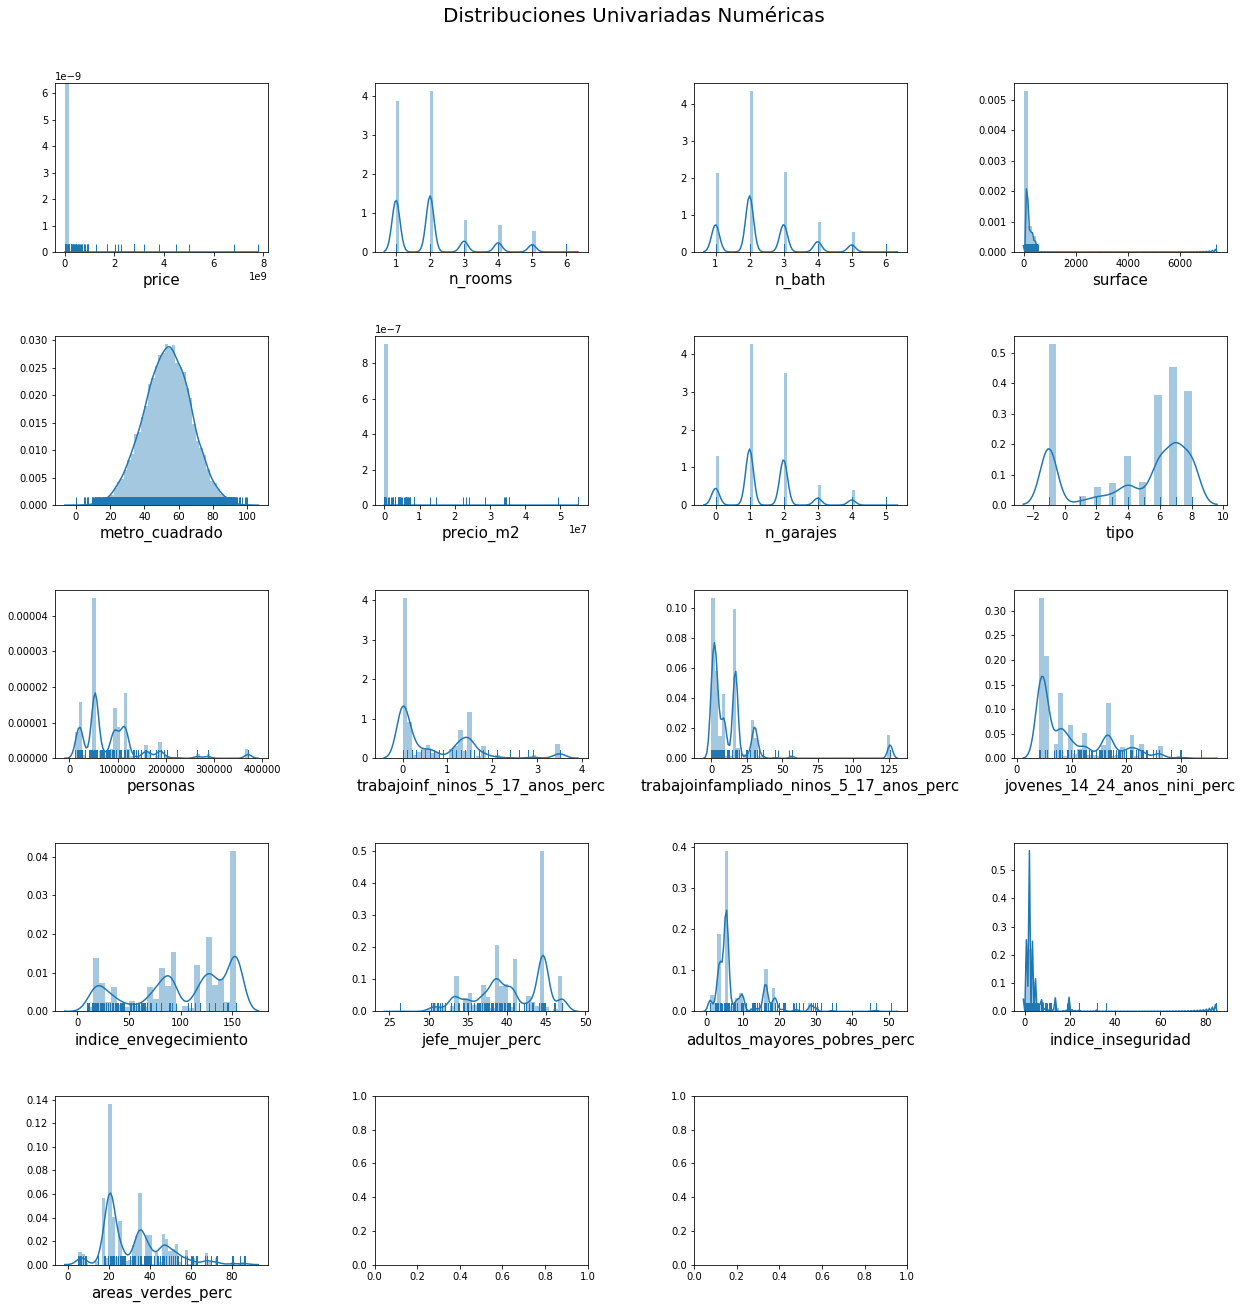

In [90]:
# Grilla de subplots
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=[17, 17])

# Se remueven el ultimo plot
list(map(lambda a : a.remove(), ax[-1,-1:]))

# Se ajusta el espaciado exterior de la figura
fig.tight_layout()

# Se define un titulo y su ubicacion
fig.suptitle('Distribuciones Univariadas Numéricas',
             fontsize=20,
             x=0.5,
             y=1.05)
'''
Se recorre cada axis, para cada columna del dataframe, se genera un grafico 
distinto en funcion del tipo de dato.

'''
for axis, col in zip(ax.flatten(), numeric):
    try :
        # Graficos para datos numericos
        sns.distplot(df[('numeric', col)], ax=axis, rug=True)
               
    except RuntimeError:
        sns.distplot(df[('numeric', col)], ax=axis, rug=True, kde=False)
    
    axis.set_xlabel(col, fontsize=15)

# Se ajusta el espaciado interno entre subplots
w, h = (.5, 0.5)
plt.subplots_adjust(wspace=w, hspace=h)

In [92]:
numeric

['price',
 'n_rooms',
 'n_bath',
 'surface',
 'metro_cuadrado',
 'precio_m2',
 'n_garajes',
 'tipo',
 'personas',
 'trabajoinf_ninos_5_17_anos_perc',
 'trabajoinfampliado_ninos_5_17_anos_perc',
 'jovenes_14_24_anos_nini_perc',
 'indice_envegecimiento',
 'jefe_mujer_perc',
 'adultos_mayores_pobres_perc',
 'indice_inseguridad',
 'areas_verdes_perc']

In [87]:
df[('numeric','precio_m2')].max()

54942028.98550725

In [97]:
list(zip(ax.flatten(),numeric))

[(<matplotlib.axes._subplots.AxesSubplot at 0x1a2be48be88>, 'price'),
 (<matplotlib.axes._subplots.AxesSubplot at 0x1a2bf807108>, 'n_rooms'),
 (<matplotlib.axes._subplots.AxesSubplot at 0x1a2bf818988>, 'n_bath'),
 (<matplotlib.axes._subplots.AxesSubplot at 0x1a2bfef0488>, 'surface'),
 (<matplotlib.axes._subplots.AxesSubplot at 0x1a2bff04f08>, 'metro_cuadrado'),
 (<matplotlib.axes._subplots.AxesSubplot at 0x1a2bff2a908>, 'precio_m2'),
 (<matplotlib.axes._subplots.AxesSubplot at 0x1a2bff576c8>, 'n_garajes'),
 (<matplotlib.axes._subplots.AxesSubplot at 0x1a2bff83988>, 'tipo'),
 (<matplotlib.axes._subplots.AxesSubplot at 0x1a2bffaeb88>, 'personas'),
 (<matplotlib.axes._subplots.AxesSubplot at 0x1a2bffdae48>,
  'trabajoinf_ninos_5_17_anos_perc'),
 (<matplotlib.axes._subplots.AxesSubplot at 0x1a2c0005f88>,
  'trabajoinfampliado_ninos_5_17_anos_perc'),
 (<matplotlib.axes._subplots.AxesSubplot at 0x1a2c0036248>,
  'jovenes_14_24_anos_nini_perc'),
 (<matplotlib.axes._subplots.AxesSubplot at 0x1

# P3


### Teórica

### Implemetación. 1

In [54]:
from sklearn.base import BaseEstimator, RegressorMixin
from numpy import matmul
from numpy.linalg import inv, eig
import sys
import time

class RegresionBayesianaEmpirica(BaseEstimator, RegressorMixin):
    def __init__(self, alpha, beta, tol=1e-5, maxiter=200):
        self.maxiter = maxiter
        self.tol = tol
        self.alpha = alpha
        self.beta = beta
        self.M_n = None
        self.S_n = None
        
    
    def get_posteriori(self, X, y, alpha, beta):
        S_n = alpha + beta*matmul(X.T, X)
        M_n = beta * matmul(matmul(inv(S_n), X.T), y)
        return M_n, S_n
    
        
    
    def fit(self, X, y):
        N = len(y)
        for i in range(self.maxiter):
            t0 = time.time()
            eigen_values, _ = eig(self.beta * matmul(X.T, X))
            gamma = (eigen_values/(self.alpha + eigen_values)).sum()
            M_n, S_n = self.get_posteriori(X, y, self.alpha, self.beta)
    
            new_alpha = gamma/(matmul(M_n.T, M_n))
            new_beta = (N-gamma)/((y - matmul(M_n.T, X))**2).sum()
            
            alpha_delta = np.abs(self.alpha - new_alpha)
            beta_delta = np.abs(self.beta - new_beta)
            
            sys.stdout.write(
                      '\rIter:{0:03d}'.format(i) + ' Alpha delta:{0:.10f}'.format(alpha_delta)
                      + ' Beta Delta:{0:.10f}'.format(beta_delta) 
                      + ' Tiempo/iter:{0:.10f}s'.format(time.time()- t0))   
            
            if (alpha_delta > self.tol or beta_delta > self.tol):
                self.alpha = new_alpha
                self.beta = new_beta
            else:
                self.M_n = M_n
                self.S_n = S_n
                break
                    
    
    def predict(self, X_, return_std = False):
        mu = matmul(self.M_n.T, X_)
        if return_std:
            std = np.sqrt(self.beta**-1 + matmul(matmul(X_.T, self.S_n), X_) )
            return mu, std
        else:
            return mu
    

### Ejemplo

In [55]:
a = RegresionBayesianaEmpirica(1,1)

In [56]:
X = np.array([[1,5,3],[9,1,3],[11,2,4]])
y = np.array([1,2,3.4])

In [57]:
a.fit(X, y)

Iter:013 Alpha delta:0.0000045833 Beta Delta:0.0000002387 Tiempo/iter:0.0009973049s

In [58]:
a.get_params()

{'alpha': 0.18959182526699184,
 'beta': 0.0083211939097537,
 'maxiter': 200,
 'tol': 1e-05}

### Implementación. 2

In [59]:
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer


numeric_features = 'numeric_cols'

numeric_transformer = Pipeline(steps=[('StandarScaler', StandardScaler()), 
                                      ('MinMaxScaler', MinMaxScalers()), 
                                      ('PolynomialFeatures', PolynomialFeatures())])

categorical_features = 'catecorical_cols'

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder())])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                                ('cat', categorical_transformer, categorical_features)])




regressor = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RegresionBayesianaEmpirica(alpha = 0, beta = 1))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)
